# 1) Import des packages 

In [81]:
import os
import shutil
from collections import OrderedDict

import json
import matplotlib.pyplot as plt
import nibabel as nib

import numpy as np
import nnunet
import SimpleITK
import graphviz

from IPython.display import Image
import re
import pandas as pd

from skimage import metrics

# 2) Parametrages des environnements généraux de nnUNet

In [2]:
os.chdir("/scratch/aoueslati/") #Environnement principal de travail
folder_dir = os.getcwd()
mount_dir = os.path.join(folder_dir, "nnUNet_Fine-tuning")
base_dir=os.getcwd()
mount_dir

'/scratch/aoueslati/nnUNet_Fine-tuning'

In [3]:
def make_if_dont_exist(folder_path,overwrite=False):      
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

In [4]:
print("Current Working Directory {}".format(folder_dir))
path_dict = {
    "nnUNet_raw_data_base" : os.path.join(mount_dir, "nnUNet_raw_data_base"), 
    "nnUNet_preprocessed" : os.path.join(mount_dir, "nnUNet_preprocessed"), 
    "RESULTS_FOLDER" : os.path.join(mount_dir, "nnUNet_Results_Folder"),
    "RAW_DATA_PATH" : os.path.join(mount_dir, "RawData"), 
    "Trainings_launcher" : os.path.join(mount_dir, "Trainings_launcher"),
    "to_predict" : os.path.join(mount_dir, "to_predict"),
    "predicted" : os.path.join(mount_dir, "predicted"),
    "Predict_launcher" : os.path.join(mount_dir, "Predict_launcher")
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
    if os.getenv(env_var) != path:
        print("Error:")
        print("Environment Variable {} is not set correctly!".format(env_var))
        print("Should be {}".format(path))
        print("Variable is {}".format(os.getenv(env_var)))
    make_if_dont_exist(path, overwrite=False)

Current Working Directory /scratch/aoueslati
/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_raw_data_base exists.
/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_preprocessed exists.
/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_Results_Folder exists.
/scratch/aoueslati/nnUNet_Fine-tuning/RawData exists.
/scratch/aoueslati/nnUNet_Fine-tuning/Trainings_launcher exists.
/scratch/aoueslati/nnUNet_Fine-tuning/to_predict exists.
/scratch/aoueslati/nnUNet_Fine-tuning/predicted exists.
/scratch/aoueslati/nnUNet_Fine-tuning/Predict_launcher exists.


# 3) Parametrages des environnements de notre modèle nnUNet

## a) Installation du modèle pré-entrainé

Tâche 105 de nnUNet pré-entrainé sur 50 sujets : Segmentation d'IRMs Cérébrales en 9 classes distinctes 

In [14]:
os.chdir(os.path.join(mount_dir, "RawData"))
!wget https://amubox.univ-amu.fr/s/8Wpazd9y52cJXEZ/download/nnunet_105.zip

--2022-06-21 16:15:52--  https://amubox.univ-amu.fr/s/8Wpazd9y52cJXEZ/download/nnunet_105.zip
Resolving amubox.univ-amu.fr (amubox.univ-amu.fr)... 139.124.245.127
Connecting to amubox.univ-amu.fr (amubox.univ-amu.fr)|139.124.245.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1147990500 (1.1G) [application/zip]
Saving to: 'nnunet_105.zip'

nnunet_105.zip      100%[===================>]   1.07G   202MB/s    in 5.4s    

2022-06-21 16:15:57 (203 MB/s) - 'nnunet_105.zip' saved [1147990500/1147990500]



In [15]:
!nnUNet_install_pretrained_model_from_zip nnunet_105.zip



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



## b) Prédiction sur 14 sujets avant Fine-Tuning

In [30]:
make_if_dont_exist('/scratch/aoueslati/nnUNet_Fine-tuning/predicted/pre_fine-tuning', overwrite=False)

/scratch/aoueslati/nnUNet_Fine-tuning/predicted/pre_fine-tuning created!


In [24]:
!scp -r /scratch/apron/data/datasets/MarsFet/derivatives/segmentation/nnunet/t2_fine_tuning /scratch/aoueslati/nnUNet_Fine-tuning/to_predict

In [28]:
os.chdir(os.path.join(mount_dir, "Predict_launcher"))

In [40]:
%%writefile -a predict_prefine-tuning.sh
#!/bin/sh
# script Bash pour l'execution d'une tach par slum.
## Finetuning
#SBATCH -J FineTuning1


# Source slurm configuration files
# GENERIC CONFIGURATION FOR COMPUTATION ON THE AIX-MARSEILLE MESOCENTRE

# Generic configuration
#SBATCH --account='b219'  # identifier of the related Mesocentre Project

# Mailing configuration
#SBATCH --mail-type=ALL  # Mail notification of the events concerning the job : start$
#SBATCH --mail-user=oueslati.anis@live.fr


# Deep Learning configuration
#SBATCH --partition=volta  # partition with gpu
#SBATCH --gres=gpu:1
#SBATCH -c 10
#SBATCH --time=96:00:00

# Files pattern
#SBATCH -e nnunet-%j_3d_full_res.err
#SBATCH -o nnunet-%j_3d_full_res.out

nnUNet_predict -t 105 -tr nnUNetTrainerV2 -i /scratch/aoueslati/nnUNet_Fine-tuning/to_predict/t2_fine_tuning -o /scratch/aoueslati/nnUNet_Fine-tuning/predicted/pre_fine-tuning



Writing predict_prefine-tuning.sh


In [ ]:
!sbatch predict_prefine-tuning.sh

In [40]:
cerveau1 = nib.load('/scratch/aoueslati/nnUNet_Fine-tuning/predicted/pre_fine-tuning/sub-0002_ses-0003_haste_t2_masked.nii.gz').get_fdata()
cerveau2 = nib.load('/scratch/aoueslati/nnUNet_Fine-tuning/predicted/pre_fine-tuning/sub-0019_ses-0022_haste_t2_masked.nii.gz').get_fdata()

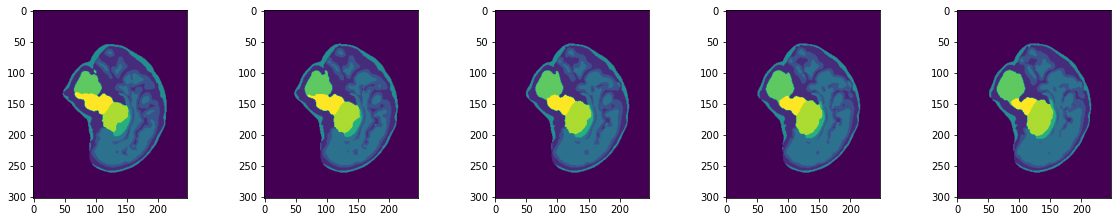

In [71]:
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(cerveau1[120 + i,:,:])
plt.show()

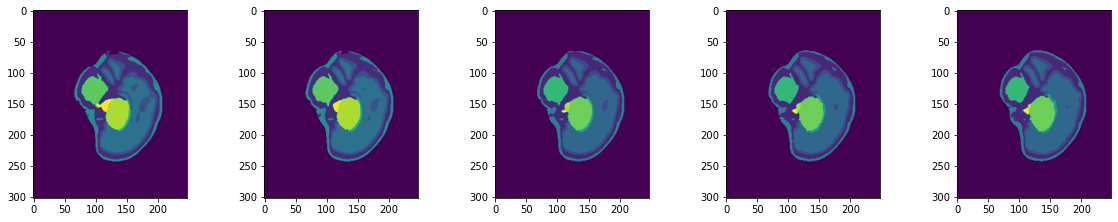

In [72]:
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(cerveau2[120 + i,:,:])
plt.show()

## c) Mise en place fine-tuning

5 sujets munis de leur ground_truth. Tâche identique

In [42]:
os.chdir(mount_dir)

# Create Folderstructure for the new task!
task_name = 'Task105_DHCP_RIB_MASKED' 
nnunet_raw_data = os.path.join(os.getenv("nnUNet_raw_data_base"), "nnUNet_raw_data")
task_folder_name = os.path.join(nnunet_raw_data,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr') 
train_label_dir = os.path.join(task_folder_name,'labelsTr') 
test_dir = os.path.join(task_folder_name,'imagesTs')        
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

# Create Folder Structure for the DHCP_RIB_MASKED Task on the system
make_if_dont_exist(task_folder_name)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir)

training_data_name="ground_truth"      
test_data_name=""

/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_raw_data_base/nnUNet_raw_data/Task105_DHCP_RIB_MASKED created!
/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_raw_data_base/nnUNet_raw_data/Task105_DHCP_RIB_MASKED/imagesTr created!
/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_raw_data_base/nnUNet_raw_data/Task105_DHCP_RIB_MASKED/labelsTr created!
/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_raw_data_base/nnUNet_raw_data/Task105_DHCP_RIB_MASKED/imagesTs created!


In [43]:
os.chdir(task_folder_name)
# download training data
!wget https://amubox.univ-amu.fr/s/ETWiAynGTFeB9xg/download/ground_truth.zip
os.chdir(base_dir)

--2022-06-21 16:51:12--  https://amubox.univ-amu.fr/s/ETWiAynGTFeB9xg/download/ground_truth.zip
Resolving amubox.univ-amu.fr (amubox.univ-amu.fr)... 139.124.245.127
Connecting to amubox.univ-amu.fr (amubox.univ-amu.fr)|139.124.245.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'ground_truth.zip'

ground_truth.zip        [      <=>           ]  46.22M  41.4MB/s    in 1.1s    

2022-06-21 16:51:13 (41.4 MB/s) - 'ground_truth.zip' saved [48470194]



In [44]:
#unzipping in nnUNet_raw folder the training data
os.chdir(task_folder_name)
!unzip ground_truth.zip
os.chdir(base_dir)

Archive:  ground_truth.zip
   creating: ground_truth/
   creating: ground_truth/manual_seg/
 extracting: ground_truth/manual_seg/sub-0307_ses-0369_haste_t2_masked.nii.gz  
 extracting: ground_truth/manual_seg/sub-0427_ses-0517_haste_t2_masked.nii.gz  
 extracting: ground_truth/manual_seg/sub-0457_ses-0549_haste_t2_masked.nii.gz  
 extracting: ground_truth/manual_seg/sub-0483_ses-0589_haste_t2_masked.nii.gz  
 extracting: ground_truth/manual_seg/sub-0665_ses-0791_haste_t2_masked.nii.gz  
   creating: ground_truth/t2/
 extracting: ground_truth/t2/sub-0307_ses-0369_haste_t2_masked.nii.gz  
 extracting: ground_truth/t2/sub-0427_ses-0517_haste_t2_masked.nii.gz  
 extracting: ground_truth/t2/sub-0457_ses-0549_haste_t2_masked.nii.gz  
 extracting: ground_truth/t2/sub-0483_ses-0589_haste_t2_masked.nii.gz  
 extracting: ground_truth/t2/sub-0665_ses-0791_haste_t2_masked.nii.gz  


### Adaptation des données pour nnUNet

In [45]:
# function for copying, savind and renaming
def copy_and_rename(old_location,old_file_name,new_location,new_filename,delete_original = False):

    shutil.copy(os.path.join(old_location,old_file_name),new_location)
    os.rename(os.path.join(new_location,old_file_name),os.path.join(new_location,new_filename))
    if delete_original:
        os.remove(os.path.join(old_location,old_file_name))

In [46]:
# putting training images into folder

mask_count1 = 1 # change if more mask is available
base_data_folder_name1 = os.path.join(task_folder_name, 'ground_truth/t2')

for file in os.listdir(base_data_folder_name1):
    # print(file)
    if file.endswith('.nii.gz'):
        if file.find('mask')!=-1:
            # putting mask
            shutil.move(os.path.join(base_data_folder_name1,file),train_image_dir)
        else:
            # making 4 copies
            for mask in range(1,mask_count1+1):
                new_filename1 = file[:file.find('-image')] + '-mask-r' + str(mask) + '.nii.gz'
                if mask==mask_count1:
                    copy_and_rename(base_data_folder_name1,file,train_image_dir,new_filename1,delete_original = True)
                else:
                    copy_and_rename(base_data_folder_name1,file,train_image_dir,new_filename1)
    # removing all other files installed due to the unzip
    elif file.endswith('.txt'):
        os.remove(os.path.join(base_data_folder_name1,file))



mask_count2 = 1 # change if more mask is available
base_data_folder_name2 = os.path.join(task_folder_name, 'ground_truth/manual_seg')



for file in os.listdir(base_data_folder_name2):
    # print(file)
    if file.endswith('.nii.gz'):
        if file.find('mask')!=-1:
            # putting mask
            shutil.move(os.path.join(base_data_folder_name2,file),train_label_dir)
        else:
            # making 4 copies
            for mask in range(1,mask_count2+1):
                new_filename2 = file[:file.find('-image')] + '-mask-r' + str(mask) + '.nii.gz'
                if mask==mask_count2:
                    copy_and_rename(base_data_folder_name2,file,train_label_dir,new_filename2,delete_original = True)
                else:
                    copy_and_rename(base_data_folder_name2,file,train_label_dir,new_filename2)
    # removing all other files installed due to the unzip
    elif file.endswith('.txt'):
        os.remove(os.path.join(base_data_folder_name2,file))

In [47]:
def check_modality(filename):
    """
    check for the existence of modality
    return False if modality is not found else True
    """
    end = filename.find('.nii.gz')
    modality = filename[end-4:end]
    for mod in modality: 
        if not(ord(mod)>=48 and ord(mod)<=57): #if not in 0 to 9 digits
            return False
    return True

def rename_for_single_modality(directory):
    
    for file in os.listdir(directory):
        
        if check_modality(file)==False:
            new_name = file[:file.find('.nii.gz')]+"_0000.nii.gz"
            os.rename(os.path.join(directory,file),os.path.join(directory,new_name))
            print(f"Renamed to {new_name}")
        else:
            print(f"Modality present: {file}")

rename_for_single_modality(train_image_dir)

Renamed to sub-0665_ses-0791_haste_t2_masked_0000.nii.gz
Renamed to sub-0483_ses-0589_haste_t2_masked_0000.nii.gz
Renamed to sub-0457_ses-0549_haste_t2_masked_0000.nii.gz
Renamed to sub-0307_ses-0369_haste_t2_masked_0000.nii.gz
Renamed to sub-0427_ses-0517_haste_t2_masked_0000.nii.gz


In [48]:
train_files = os.listdir(train_image_dir)
label_files = os.listdir(train_label_dir)
print("train image files:",len(train_files))
print("train label files:",len(label_files))

train image files: 5
train label files: 5


## c) Paramétrage de l'entrainement

### - Choix du nombre de classes des données +  modalités

In [49]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "MRI Segmentation"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "INT"
    json_dict['licence'] = "nnUNET"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "MRI"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "a",
        "1": "b",
        "2": "c",
        "3": "d",
        "4": "e",
        "5": "f",
        "6": "g",
        "7": "h",
        "8": "i",
        "9": "j"
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json created!


### - Création d'un nouveau ClassTrainer en vue du Fine-Tuning

In [50]:
os.chdir(os.path.join(base_dir, "nnUNet/nnunet/training/network_training/")) #Environnement principal de travail

In [51]:
%%writefile -a nnUNetTrainerV3.py 
#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.


from collections import OrderedDict
from typing import Tuple

import numpy as np
import torch
from nnunet.training.data_augmentation.data_augmentation_moreDA import get_moreDA_augmentation
from nnunet.training.loss_functions.deep_supervision import MultipleOutputLoss2
from nnunet.utilities.to_torch import maybe_to_torch, to_cuda
from nnunet.network_architecture.generic_UNet import Generic_UNet
from nnunet.network_architecture.initialization import InitWeights_He
from nnunet.network_architecture.neural_network import SegmentationNetwork
from nnunet.training.data_augmentation.default_data_augmentation import default_2D_augmentation_params, \
    get_patch_size, default_3D_augmentation_params
from nnunet.training.dataloading.dataset_loading import unpack_dataset
from nnunet.training.network_training.nnUNetTrainer import nnUNetTrainer
from nnunet.utilities.nd_softmax import softmax_helper
from sklearn.model_selection import KFold
from torch import nn
from torch.cuda.amp import autocast
from nnunet.training.learning_rate.poly_lr import poly_lr
from batchgenerators.utilities.file_and_folder_operations import *


class nnUNetTrainerV3(nnUNetTrainer):
    """
    Info for Fabian: same as internal nnUNetTrainerV2_2
    """

    def __init__(self, plans_file, fold, output_folder=None, dataset_directory=None, batch_dice=True, stage=None,
                 unpack_data=True, deterministic=True, fp16=False):
        super().__init__(plans_file, fold, output_folder, dataset_directory, batch_dice, stage, unpack_data,
                         deterministic, fp16)
        self.max_num_epochs = 150            #Modification du nombre d'epochs
        self.initial_lr = 1e-3               #Modification du learning rate  
        self.deep_supervision_scales = None
        self.ds_loss_weights = None

        self.pin_memory = True

    def initialize(self, training=True, force_load_plans=False):
        """
        - replaced get_default_augmentation with get_moreDA_augmentation
        - enforce to only run this code once
        - loss function wrapper for deep supervision
        :param training:
        :param force_load_plans:
        :return:
        """
        if not self.was_initialized:
            maybe_mkdir_p(self.output_folder)

            if force_load_plans or (self.plans is None):
                self.load_plans_file()

            self.process_plans(self.plans)

            self.setup_DA_params()

            ################# Here we wrap the loss for deep supervision ############
            # we need to know the number of outputs of the network
            net_numpool = len(self.net_num_pool_op_kernel_sizes)

            # we give each output a weight which decreases exponentially (division by 2) as the resolution decreases
            # this gives higher resolution outputs more weight in the loss
            weights = np.array([1 / (2 ** i) for i in range(net_numpool)])

            # we don't use the lowest 2 outputs. Normalize weights so that they sum to 1
            mask = np.array([True] + [True if i < net_numpool - 1 else False for i in range(1, net_numpool)])
            weights[~mask] = 0
            weights = weights / weights.sum()
            self.ds_loss_weights = weights
            # now wrap the loss
            self.loss = MultipleOutputLoss2(self.loss, self.ds_loss_weights)
            ################# END ###################

            self.folder_with_preprocessed_data = join(self.dataset_directory, self.plans['data_identifier'] +
                                                      "_stage%d" % self.stage)
            if training:
                self.dl_tr, self.dl_val = self.get_basic_generators()
                if self.unpack_data:
                    print("unpacking dataset")
                    unpack_dataset(self.folder_with_preprocessed_data)
                    print("done")
                else:
                    print(
                        "INFO: Not unpacking data! Training may be slow due to that. Pray you are not using 2d or you "
                        "will wait all winter for your model to finish!")

                self.tr_gen, self.val_gen = get_moreDA_augmentation(
                    self.dl_tr, self.dl_val,
                    self.data_aug_params[
                        'patch_size_for_spatialtransform'],
                    self.data_aug_params,
                    deep_supervision_scales=self.deep_supervision_scales,
                    pin_memory=self.pin_memory,
                    use_nondetMultiThreadedAugmenter=False
                )
                self.print_to_log_file("TRAINING KEYS:\n %s" % (str(self.dataset_tr.keys())),
                                       also_print_to_console=False)
                self.print_to_log_file("VALIDATION KEYS:\n %s" % (str(self.dataset_val.keys())),
                                       also_print_to_console=False)
            else:
                pass

            self.initialize_network()
            self.initialize_optimizer_and_scheduler()

            assert isinstance(self.network, (SegmentationNetwork, nn.DataParallel))
        else:
            self.print_to_log_file('self.was_initialized is True, not running self.initialize again')
        self.was_initialized = True

    def initialize_network(self):
        """
        - momentum 0.99
        - SGD instead of Adam
        - self.lr_scheduler = None because we do poly_lr
        - deep supervision = True
        - i am sure I forgot something here
        Known issue: forgot to set neg_slope=0 in InitWeights_He; should not make a difference though
        :return:
        """
        if self.threeD:
            conv_op = nn.Conv3d
            dropout_op = nn.Dropout3d
            norm_op = nn.InstanceNorm3d

        else:
            conv_op = nn.Conv2d
            dropout_op = nn.Dropout2d
            norm_op = nn.InstanceNorm2d

        norm_op_kwargs = {'eps': 1e-5, 'affine': True}
        dropout_op_kwargs = {'p': 0, 'inplace': True}
        net_nonlin = nn.LeakyReLU
        net_nonlin_kwargs = {'negative_slope': 1e-2, 'inplace': True}
        self.network = Generic_UNet(self.num_input_channels, self.base_num_features, self.num_classes,
                                    len(self.net_num_pool_op_kernel_sizes),
                                    self.conv_per_stage, 2, conv_op, norm_op, norm_op_kwargs, dropout_op,
                                    dropout_op_kwargs,
                                    net_nonlin, net_nonlin_kwargs, True, False, lambda x: x, InitWeights_He(1e-2),
                                    self.net_num_pool_op_kernel_sizes, self.net_conv_kernel_sizes, False, True, True)
        if torch.cuda.is_available():
            self.network.cuda()
        self.network.inference_apply_nonlin = softmax_helper

    def initialize_optimizer_and_scheduler(self):
        assert self.network is not None, "self.initialize_network must be called first"
        self.optimizer = torch.optim.SGD(self.network.parameters(), self.initial_lr, weight_decay=self.weight_decay,
                                         momentum=0.99, nesterov=True)
        self.lr_scheduler = None

    def run_online_evaluation(self, output, target):
        """
        due to deep supervision the return value and the reference are now lists of tensors. We only need the full
        resolution output because this is what we are interested in in the end. The others are ignored
        :param output:
        :param target:
        :return:
        """
        target = target[0]
        output = output[0]
        return super().run_online_evaluation(output, target)

    def validate(self, do_mirroring: bool = True, use_sliding_window: bool = True,
                 step_size: float = 0.5, save_softmax: bool = True, use_gaussian: bool = True, overwrite: bool = True,
                 validation_folder_name: str = 'validation_raw', debug: bool = False, all_in_gpu: bool = False,
                 segmentation_export_kwargs: dict = None, run_postprocessing_on_folds: bool = True):
        """
        We need to wrap this because we need to enforce self.network.do_ds = False for prediction
        """
        ds = self.network.do_ds
        self.network.do_ds = False
        ret = super().validate(do_mirroring=do_mirroring, use_sliding_window=use_sliding_window, step_size=step_size,
                               save_softmax=save_softmax, use_gaussian=use_gaussian,
                               overwrite=overwrite, validation_folder_name=validation_folder_name, debug=debug,
                               all_in_gpu=all_in_gpu, segmentation_export_kwargs=segmentation_export_kwargs,
                               run_postprocessing_on_folds=run_postprocessing_on_folds)

        self.network.do_ds = ds
        return ret

    def predict_preprocessed_data_return_seg_and_softmax(self, data: np.ndarray, do_mirroring: bool = True,
                                                         mirror_axes: Tuple[int] = None,
                                                         use_sliding_window: bool = True, step_size: float = 0.5,
                                                         use_gaussian: bool = True, pad_border_mode: str = 'constant',
                                                         pad_kwargs: dict = None, all_in_gpu: bool = False,
                                                         verbose: bool = True, mixed_precision=True) -> Tuple[np.ndarray, np.ndarray]:
        """
        We need to wrap this because we need to enforce self.network.do_ds = False for prediction
        """
        ds = self.network.do_ds
        self.network.do_ds = False
        ret = super().predict_preprocessed_data_return_seg_and_softmax(data,
                                                                       do_mirroring=do_mirroring,
                                                                       mirror_axes=mirror_axes,
                                                                       use_sliding_window=use_sliding_window,
                                                                       step_size=step_size, use_gaussian=use_gaussian,
                                                                       pad_border_mode=pad_border_mode,
                                                                       pad_kwargs=pad_kwargs, all_in_gpu=all_in_gpu,
                                                                       verbose=verbose,
                                                                       mixed_precision=mixed_precision)
        self.network.do_ds = ds
        return ret

    def run_iteration(self, data_generator, do_backprop=True, run_online_evaluation=False):
        """
        gradient clipping improves training stability
        :param data_generator:
        :param do_backprop:
        :param run_online_evaluation:
        :return:
        """
        data_dict = next(data_generator)
        data = data_dict['data']
        target = data_dict['target']

        data = maybe_to_torch(data)
        target = maybe_to_torch(target)

        if torch.cuda.is_available():
            data = to_cuda(data)
            target = to_cuda(target)

        self.optimizer.zero_grad()

        if self.fp16:
            with autocast():
                output = self.network(data)
                del data
                l = self.loss(output, target)

            if do_backprop:
                self.amp_grad_scaler.scale(l).backward()
                self.amp_grad_scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 12)
                self.amp_grad_scaler.step(self.optimizer)
                self.amp_grad_scaler.update()
        else:
            output = self.network(data)
            del data
            l = self.loss(output, target)

            if do_backprop:
                l.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 12)
                self.optimizer.step()

        if run_online_evaluation:
            self.run_online_evaluation(output, target)

        del target

        return l.detach().cpu().numpy()

    def do_split(self):
        """
        The default split is a 5 fold CV on all available training cases. nnU-Net will create a split (it is seeded,
        so always the same) and save it as splits_final.pkl file in the preprocessed data directory.
        Sometimes you may want to create your own split for various reasons. For this you will need to create your own
        splits_final.pkl file. If this file is present, nnU-Net is going to use it and whatever splits are defined in
        it. You can create as many splits in this file as you want. Note that if you define only 4 splits (fold 0-3)
        and then set fold=4 when training (that would be the fifth split), nnU-Net will print a warning and proceed to
        use a random 80:20 data split.
        :return:
        """
        if self.fold == "all":
            # if fold==all then we use all images for training and validation
            tr_keys = val_keys = list(self.dataset.keys())
        else:
            splits_file = join(self.dataset_directory, "splits_final.pkl")

            # if the split file does not exist we need to create it
            if not isfile(splits_file):
                self.print_to_log_file("Creating new 5-fold cross-validation split...")
                splits = []
                all_keys_sorted = np.sort(list(self.dataset.keys()))
                kfold = KFold(n_splits=5, shuffle=True, random_state=12345)
                for i, (train_idx, test_idx) in enumerate(kfold.split(all_keys_sorted)):
                    train_keys = np.array(all_keys_sorted)[train_idx]
                    test_keys = np.array(all_keys_sorted)[test_idx]
                    splits.append(OrderedDict())
                    splits[-1]['train'] = train_keys
                    splits[-1]['val'] = test_keys
                save_pickle(splits, splits_file)

            else:
                self.print_to_log_file("Using splits from existing split file:", splits_file)
                splits = load_pickle(splits_file)
                self.print_to_log_file("The split file contains %d splits." % len(splits))

            self.print_to_log_file("Desired fold for training: %d" % self.fold)
            if self.fold < len(splits):
                tr_keys = splits[self.fold]['train']
                val_keys = splits[self.fold]['val']
                self.print_to_log_file("This split has %d training and %d validation cases."
                                       % (len(tr_keys), len(val_keys)))
            else:
                self.print_to_log_file("INFO: You requested fold %d for training but splits "
                                       "contain only %d folds. I am now creating a "
                                       "random (but seeded) 80:20 split!" % (self.fold, len(splits)))
                # if we request a fold that is not in the split file, create a random 80:20 split
                rnd = np.random.RandomState(seed=12345 + self.fold)
                keys = np.sort(list(self.dataset.keys()))
                idx_tr = rnd.choice(len(keys), int(len(keys) * 0.8), replace=False)
                idx_val = [i for i in range(len(keys)) if i not in idx_tr]
                tr_keys = [keys[i] for i in idx_tr]
                val_keys = [keys[i] for i in idx_val]
                self.print_to_log_file("This random 80:20 split has %d training and %d validation cases."
                                       % (len(tr_keys), len(val_keys)))

        tr_keys.sort()
        val_keys.sort()
        self.dataset_tr = OrderedDict()
        for i in tr_keys:
            self.dataset_tr[i] = self.dataset[i]
        self.dataset_val = OrderedDict()
        for i in val_keys:
            self.dataset_val[i] = self.dataset[i]

    def setup_DA_params(self):
        """
        - we increase roation angle from [-15, 15] to [-30, 30]
        - scale range is now (0.7, 1.4), was (0.85, 1.25)
        - we don't do elastic deformation anymore
        :return:
        """

        self.deep_supervision_scales = [[1, 1, 1]] + list(list(i) for i in 1 / np.cumprod(
            np.vstack(self.net_num_pool_op_kernel_sizes), axis=0))[:-1]

        if self.threeD:
            self.data_aug_params = default_3D_augmentation_params
            self.data_aug_params['rotation_x'] = (-30. / 360 * 2. * np.pi, 30. / 360 * 2. * np.pi)
            self.data_aug_params['rotation_y'] = (-30. / 360 * 2. * np.pi, 30. / 360 * 2. * np.pi)
            self.data_aug_params['rotation_z'] = (-30. / 360 * 2. * np.pi, 30. / 360 * 2. * np.pi)
            if self.do_dummy_2D_aug:
                self.data_aug_params["dummy_2D"] = True
                self.print_to_log_file("Using dummy2d data augmentation")
                self.data_aug_params["elastic_deform_alpha"] = \
                    default_2D_augmentation_params["elastic_deform_alpha"]
                self.data_aug_params["elastic_deform_sigma"] = \
                    default_2D_augmentation_params["elastic_deform_sigma"]
                self.data_aug_params["rotation_x"] = default_2D_augmentation_params["rotation_x"]
        else:
            self.do_dummy_2D_aug = False
            if max(self.patch_size) / min(self.patch_size) > 1.5:
                default_2D_augmentation_params['rotation_x'] = (-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi)
            self.data_aug_params = default_2D_augmentation_params
        self.data_aug_params["mask_was_used_for_normalization"] = self.use_mask_for_norm

        if self.do_dummy_2D_aug:
            self.basic_generator_patch_size = get_patch_size(self.patch_size[1:],
                                                             self.data_aug_params['rotation_x'],
                                                             self.data_aug_params['rotation_y'],
                                                             self.data_aug_params['rotation_z'],
                                                             self.data_aug_params['scale_range'])
            self.basic_generator_patch_size = np.array([self.patch_size[0]] + list(self.basic_generator_patch_size))
        else:
            self.basic_generator_patch_size = get_patch_size(self.patch_size, self.data_aug_params['rotation_x'],
                                                             self.data_aug_params['rotation_y'],
                                                             self.data_aug_params['rotation_z'],
                                                             self.data_aug_params['scale_range'])

        self.data_aug_params["scale_range"] = (0.7, 1.4)
        self.data_aug_params["do_elastic"] = False
        self.data_aug_params['selected_seg_channels'] = [0]
        self.data_aug_params['patch_size_for_spatialtransform'] = self.patch_size

        self.data_aug_params["num_cached_per_thread"] = 2

    def maybe_update_lr(self, epoch=None):
        """
        if epoch is not None we overwrite epoch. Else we use epoch = self.epoch + 1
        (maybe_update_lr is called in on_epoch_end which is called before epoch is incremented.
        herefore we need to do +1 here)
        :param epoch:
        :return:
        """
        if epoch is None:
            ep = self.epoch + 1
        else:
            ep = epoch
        self.optimizer.param_groups[0]['lr'] = poly_lr(ep, self.max_num_epochs, self.initial_lr, 0.9)
        self.print_to_log_file("lr:", np.round(self.optimizer.param_groups[0]['lr'], decimals=6))

    def on_epoch_end(self):
        """
        overwrite patient-based early stopping. Always run to 1000 epochs
        :return:
        """
        super().on_epoch_end()
        continue_training = self.epoch < self.max_num_epochs

        # it can rarely happen that the momentum of nnUNetTrainerV2 is too high for some dataset. If at epoch 100 the
        # estimated validation Dice is still 0 then we reduce the momentum from 0.99 to 0.95
        if self.epoch == 100:
            if self.all_val_eval_metrics[-1] == 0:
                self.optimizer.param_groups[0]["momentum"] = 0.95
                self.network.apply(InitWeights_He(1e-2))
                self.print_to_log_file("At epoch 100, the mean foreground Dice was 0. This can be caused by a too "
                                       "high momentum. High momentum (0.99) is good for datasets where it works, but "
                                       "sometimes causes issues such as this one. Momentum has now been reduced to "
                                       "0.95 and network weights have been reinitialized")
        return continue_training

    def run_training(self):
        """
        if we run with -c then we need to set the correct lr for the first epoch, otherwise it will run the first
        continued epoch with self.initial_lr
        we also need to make sure deep supervision in the network is enabled for training, thus the wrapper
        :return:
        """
        self.maybe_update_lr(self.epoch)  # if we dont overwrite epoch then self.epoch+1 is used which is not what we
        # want at the start of the training
        ds = self.network.do_ds
        self.network.do_ds = True
        ret = super().run_training()
        self.network.do_ds = ds
        return ret



Writing nnUNetTrainerV3.py


# - Preprocess des données avant entrainement

In [52]:
!nnUNet_plan_and_preprocess -t 105 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

sub-0665_ses-0791_haste_t2_masked
sub-0427_ses-0517_haste_t2_masked
sub-0483_ses-0589_haste_t2_masked
sub-0307_ses-0369_haste_t2_masked
sub-0457_ses-0549_haste_t2_masked
before crop: (1, 248, 302, 216) after crop: (1, 155, 191, 167) spacing: [0.5 0.5 0.5] 

before crop: (1, 248, 302, 216) after crop: (1, 155, 185, 159) spacing: [0.5 0.5 0.5] 

before crop: (1, 248, 302, 216) after crop: (1, 172, 204, 177) spacing: [0.5 0.5 0.5] 

before crop: (1, 248, 302, 216) after crop: (1, 174, 214, 179) spacing: [0.5 0.5 0.5] 

before crop: (1, 248, 302, 216) after crop: (1, 160, 196, 174) spacing: [0.5 0.5 0.5] 




 Task105_DHCP_RIB_MASKED


# - Lancement d'un entrainement sur le cluster

In [9]:
os.chdir(os.path.join(mount_dir, "Trainings_launcher"))

In [19]:
%%writefile -a fine-tuning.sh
#!/bin/sh
# script Bash pour l'execution d'une tach par slum.
## Finetuning
#SBATCH -J FineTuning1


# Source slurm configuration files
# GENERIC CONFIGURATION FOR COMPUTATION ON THE AIX-MARSEILLE MESOCENTRE

# Generic configuration
#SBATCH --account='b219'  # identifier of the related Mesocentre Project

# Mailing configuration
#SBATCH --mail-type=ALL  # Mail notification of the events concerning the job : start$
#SBATCH --mail-user=oueslati.anis@live.fr


# Deep Learning configuration
#SBATCH --partition=volta  # partition with gpu
#SBATCH --gres=gpu:1
#SBATCH -c 10
#SBATCH --time=96:00:00

# Files pattern
#SBATCH -e nnunet-%j_3d_full_res.err
#SBATCH -o nnunet-%j_3d_full_res.out

for FOLD in 0 1 2 3 4
do
nnUNet_train  3d_fullres nnUNetTrainerV3 Task105_DHCP_RIB_MASKED  $FOLD
done


Writing fine-tuning.sh


In [20]:
!sbatch fine-tuning.sh

Submitted batch job 7795205


In [10]:
!nnUNet_determine_postprocessing -tr nnUNetTrainerV3 -t 105 -m 3d_fullres



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Traceback (most recent call last):
  File "/scratch/aoueslati/anaconda3/bin/nnUNet_determine_postprocessing", line 33, in <module>
    sys.exit(load_entry_point('nnunet', 'console_scripts', 'nnUNet_determine_postprocessing')())
  File "/scratch/aoueslati/nnUNet/nnunet/postprocessing/consolidate_postprocessing_simple.py", line 56, in main
    consolidate_folds(folder, val)
  File "/scratch/aoueslati/nnUNet/nnunet/postprocessing/consolidate_postprocessing.py", line 61, in consolidate_folds
    collect_cv_niftis(output_folder_base, output_folder_raw, validation_folder_name,
  File "/scratch/aoueslati/nnUNet/nnunet/postprocessing/cons

# - Interprétations des résultats 

##  Prédiction sur 14 sujets après Fine-Tuning

In [18]:
make_if_dont_exist('/scratch/aoueslati/nnUNet_Fine-tuning/predicted/post_fine-tuning', overwrite=False)

/scratch/aoueslati/nnUNet_Fine-tuning/predicted/post_fine-tuning created!


In [19]:
os.chdir(os.path.join(mount_dir, "Predict_launcher"))

In [20]:
%%writefile -a predict_postfine-tuning.sh
#!/bin/sh
# script Bash pour l'execution d'une tach par slum.
## Finetuning
#SBATCH -J FineTuning1


# Source slurm configuration files
# GENERIC CONFIGURATION FOR COMPUTATION ON THE AIX-MARSEILLE MESOCENTRE

# Generic configuration
#SBATCH --account='b219'  # identifier of the related Mesocentre Project

# Mailing configuration
#SBATCH --mail-type=ALL  # Mail notification of the events concerning the job : start$
#SBATCH --mail-user=oueslati.anis@live.fr


# Deep Learning configuration
#SBATCH --partition=volta  # partition with gpu
#SBATCH --gres=gpu:1
#SBATCH -c 10
#SBATCH --time=96:00:00

# Files pattern
#SBATCH -e nnunet-%j_3d_full_res.err
#SBATCH -o nnunet-%j_3d_full_res.out

nnUNet_predict -t 105 -tr nnUNetTrainerV3 -i /scratch/aoueslati/nnUNet_Fine-tuning/to_predict/t2_fine_tuning -o /scratch/aoueslati/nnUNet_Fine-tuning/predicted/post_fine-tuning



Writing predict_postfine-tuning.sh


In [41]:
!sbatch predict_postfine-tuning.sh

Submitted batch job 7794751


In [24]:
cerveau3 = nib.load('/scratch/aoueslati/nnUNet_Fine-tuning/predicted/post_fine-tuning/predicted/sub-0002_ses-0003_haste_t2_masked.nii.gz').get_fdata()
cerveau4 = nib.load('/scratch/aoueslati/nnUNet_Fine-tuning/predicted/post_fine-tuning/predicted/sub-0019_ses-0022_haste_t2_masked.nii.gz').get_fdata()

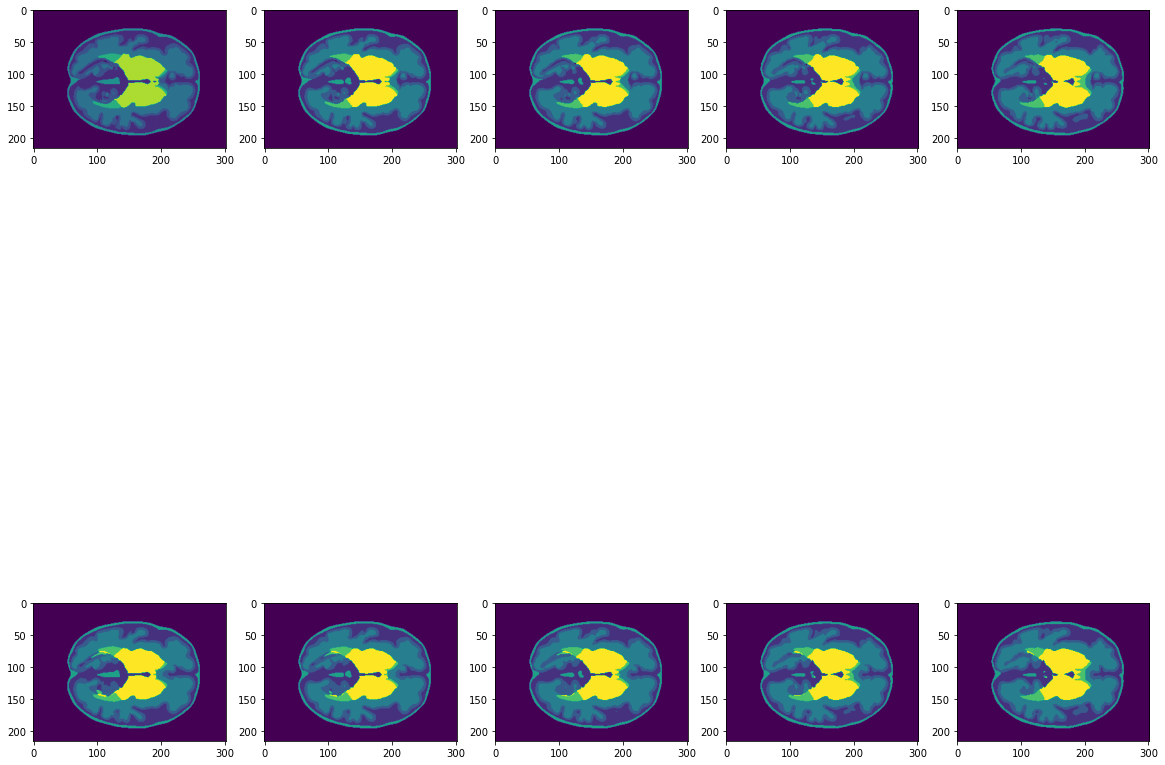

In [35]:
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(2, 5,i + 1)
    plt.imshow(cerveau1[:,:,130+i])
    plt.subplot(2, 5,i + 6)
    plt.imshow(cerveau3[:,:,130+i])
    
plt.show()

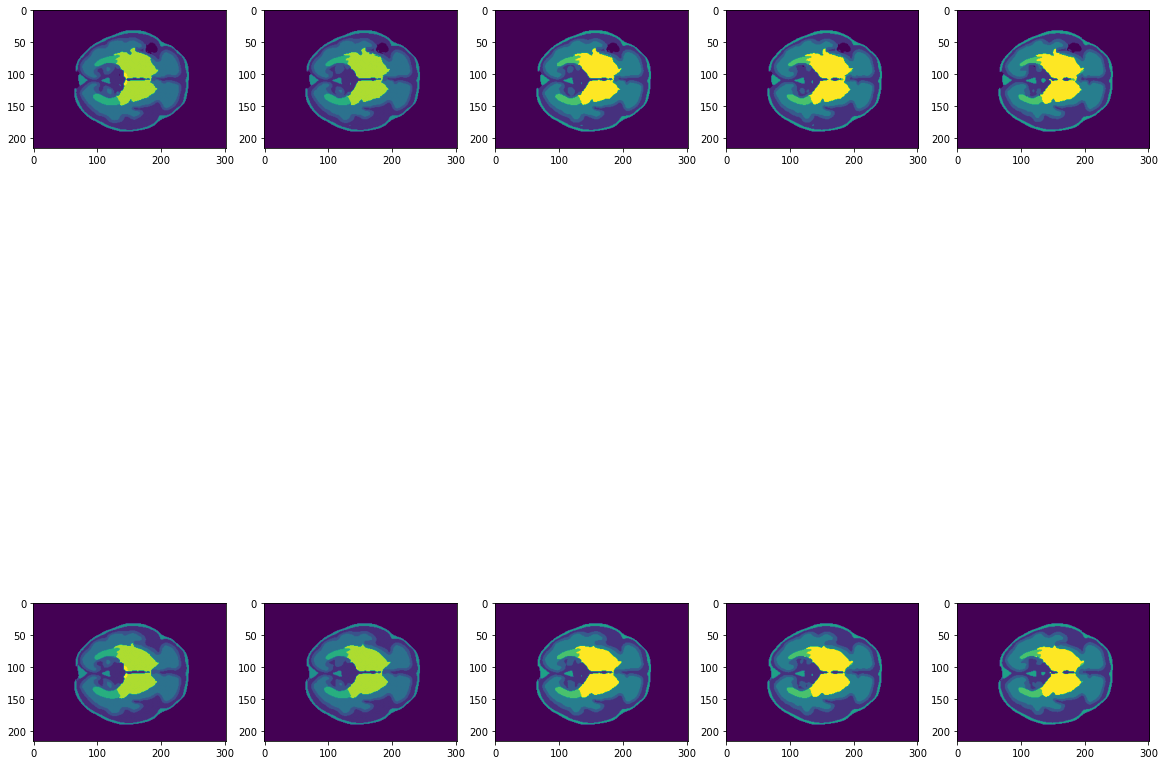

In [37]:
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(2, 5,i + 1)
    plt.imshow(cerveau2[:,:,130+i])
    plt.subplot(2, 5,i + 6)
    plt.imshow(cerveau4[:,:,130+i])
    
plt.show()

In [86]:
!nnUNet_evaluate_folder -ref /scratch/aoueslati/nnUNet_Fine-tuning/predicted/pre_fine-tuning -pred /scratch/aoueslati/nnUNet_Fine-tuning/predicted/post_fine-tuning/predicted -l 0 1 2 3 4 5 6 7 8 9 ;



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

OrderedDict([('all', [OrderedDict([('0', OrderedDict([('Accuracy', 0.9998966468070292), ('Dice', 0.9999367885259379), ('False Discovery Rate', 2.9565212920190653e-05), ('False Negative Rate', 9.68554710714109e-05), ('False Omission Rate', 0.0004338646057928545), ('False Positive Rate', 0.000132468549730258), ('Jaccard', 0.9998735850427516), ('Negative Predictive Value', 0.9995661353942071), ('Precision', 0.9999704347870798), ('Recall', 0.9999031445289286), ('Total Positives Reference', 13225892), ('Total Positives Test', 13225002), ('True Negative Rate', 0.9998675314502697)])), ('1', OrderedDict([('Accuracy', 0.9958978301763631), 

In [83]:
def get_pattern(text, pattern):
    """ """
    regex = re.compile(pattern)
    match = regex.search(text)
    if match is not None:
        return match.group()
    else:
        return None


def build_summary_df(path_summary_file):
    """
    Parse result metrics from summary.json nnunet file and build a pandas DataFrame with it
    :param path_summary_file: path of the summary.json file to consider
    :type path_summary_file:
    :return: summary_df
    :rtype:
    """

    summary_raw = pd.read_json(path_summary_file)["results"]
    summary = summary_raw[0]
    summary_df = pd.DataFrame()

    for result in summary:
        identifier = os.path.basename(result["reference"]).replace(".nii.gz", "")
        subject = get_pattern(result["reference"], "sub-\d\d\d\d")
        session = get_pattern(result["reference"], "ses-\d\d\d\d")
        sequence = get_pattern(result["reference"], "haste|tru")
        for key in result.keys():
            if key not in ["reference", "test"]:
                temp = {
                    "participant_id": subject,
                    "session_id": session,
                    "sequence": sequence,
                    "label": int(key),
                }
                temp.update(result[key])
                # print(temp)
                summary_df = summary_df.append(temp, ignore_index=True)
    return summary_df



In [88]:
results=build_summary_df(r'/scratch/aoueslati/nnUNet_Fine-tuning/predicted/post_fine-tuning/predicted/summary.json');

/tmp/ipykernel_440162/2650414618.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(temp, ignore_index=True)
/tmp/ipykernel_440162/2650414618.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(temp, ignore_index=True)
/tmp/ipykernel_440162/2650414618.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(temp, ignore_index=True)
/tmp/ipykernel_440162/2650414618.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(temp, ignore_index=True)
/tmp/ipykernel_440162/2650414618.py:39: FutureWarning: The frame.append meth

In [89]:
results

,participant_id,session_id,sequence,label,Accuracy,Dice,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,Jaccard,Negative Predictive Value,Precision,Recall,Total Positives Reference,Total Positives Test,True Negative Rate
0,sub-0002,ses-0003,haste,0,0.999897,0.999937,0.000030,0.000097,0.000434,0.000132,0.999874,0.999566,0.999970,0.999903,13225892,13225002,0.999868
1,sub-0002,ses-0003,haste,1,0.995898,0.959058,0.028977,0.052615,0.002807,0.001510,0.921337,0.997193,0.971023,0.947385,820447,800474,0.998490
2,sub-0002,ses-0003,haste,2,0.994516,0.914738,0.078281,0.092139,0.003084,0.002582,0.842873,0.996916,0.921719,0.907861,524177,516296,0.997418
3,sub-0002,ses-0003,haste,3,0.996629,0.970349,0.047961,0.010622,0.000629,0.002942,0.942406,0.999371,0.952039,0.989378,901803,937172,0.997058
4,sub-0002,ses-0003,haste,4,0.999251,0.983088,0.019180,0.014632,0.000331,0.000436,0.966739,0.999669,0.980820,0.985368,357563,359221,0.999564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,sub-0916,ses-1054,haste,5,0.999710,0.878273,0.122888,0.120563,0.000144,0.000147,0.782965,0.999856,0.877112,0.879437,19243,19294,0.999853
136,sub-0916,ses-1054,haste,6,0.998598,0.879652,0.015718,0.204870,0.001327,0.000082,0.785160,0.998673,0.984282,0.795130,104271,84233,0.999918
137,sub-0916,ses-1054,haste,7,0.998366,0.904108,0.034955,0.149590,0.001366,0.000282,0.824998,0.998634,0.965045,0.850410,146547,129139,0.999718
138,sub-0916,ses-1054,haste,8,0.999848,0.965410,0.009615,0.058336,0.000132,0.000021,0.933134,0.999868,0.990385,0.941664,36427,34635,0.999979


In [104]:
results[['Dice']].mean()

Dice    0.938005
dtype: float64

In [118]:
metrics.hausdorff_distance(cerveau1,cerveau3),metrics.hausdorff_distance(cerveau2,cerveau4)

(3.4641016151377544, 7.0710678118654755)

In [ ]:
Distance_Hausdorf=[]
for i in range 14:
    

# A REVOIR 

In [58]:
#Image('/scratch/aoueslati/nnUNet_Fine-tuning/nnUNet_Results_Folder/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV5__nnUNetPlansv2.1/fold_0/progress.png')

In [54]:
#!nnUNet_predict  -t 105 -tr nnUNetTrainerV5 -i /scratch/aoueslati/predict -o /scratch/aoueslati/predicted/ -f 0

In [5]:
#!nnUNet_find_best_configuration -m 3d_fullres -t 105

In [55]:
#import torch
#from batchgenerators.utilities.file_and_folder_operations import *
#import numpy as np
#from nnunet.paths import preprocessing_output_dir
#join(preprocessing_output_dir, task_name)

In [56]:
#task_name = 'Task105_DHCP_RIB_MASKED'
#plans_fname = join(preprocessing_output_dir, task_name, 'nnUNetPlansv2.1_plans_3D.pkl')
#plans = load_pickle(plans_fname)
#plans['plans_per_stage'][0]['batch_size'] = 2
#plans['plans_per_stage'][0]['median_patient_size_in_voxels'] = np.array([160, 196, 174])
#plans['plans_per_stage'][0]['current_spacing'] = np.array([0.5, 0.5, 0.5])
#plans['plans_per_stage'][0]['patch_size'] = np.array([128, 128, 128])
#plans['plans_per_stage'][0]['num_pool_per_axis'] = [5, 5, 5]
#plans['plans_per_stage'][0]['do_dummy_2D_data_aug'] = False
#plans['plans_per_stage'][0]['original_spacing'] = np.array([0.5, 0.5, 0.5])
#plans['plans_per_stage'][0]['pool_op_kernel_sizes'] = [[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
#plans['plans_per_stage'][0]['conv_kernel_sizes'] = [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
#save_pickle(plans, join(preprocessing_output_dir, task_name, 'NewnnUNetPlansv2.1_plans_3D.pkl'))

In [21]:
#!nnUNet_plan_and_preprocess -t 105 #-overwrite_plans NewnnUNetPlansv2.1_plans_3D.pkl -pl3d ExperimentPlanner3D_v21_Pretrained -overwrite_plans_identifier NewnnUNetPlansv2.1_plans_3D.pkl

In [16]:
#!nnUNet_plan_and_preprocess -t 105 -overwrite_plans nnUNetPlansv2.1_plans_3D.pkl -pl3d ExperimentPlanner3D_v21_Pretrained -overwrite_plans_identifier Alex

In [4]:
#!nnUNet_determine_postprocessing -m 3d_fullres -t Task105_DHCP_RIB_MASKED -tr nnUNetTrainerV4

In [54]:
#!nnUNet_plan_and_preprocess -t 105 -overwrite_plans pretrained_weights/new_model.model -pl3d ExperimentPlanner3D_v21_Pretrained -overwrite_plans_identifier pretrained_weights/new_model.model

In [1]:
#!nnUNet_train 3d_fullres nnUNetTrainerV2 Task105_DHCP_RIB_MASKED 0 -w pretrained_weights/new_model.model

In [24]:
#!nnUNet_determine_postprocessing -m 3d_fullres -t 105 -tr nnUNetTrainerV2  -val validation_raw

In [6]:
#!nano nnunet-7734648_3d_full_res.out

In [30]:
#from PIL import Image

In [29]:
#from IPython.display import Image
#Image('/scratch/aoueslati/scratch/aoueslati/nnUNET_folder/nnUNet_Results_Folder/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/progress.png')

In [27]:
#Image('/scratch/aoueslati/scratch/aoueslati/nnUNET_folder/nnUNet_Results_Folder/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV2__nnUNetPlansv2.1/fold_1/progress.png')

In [26]:
#Image('/scratch/aoueslati/scratch/aoueslati/nnUNET_folder/nnUNet_Results_Folder/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV2__nnUNetPlansv2.1/fold_2/progress.png')

In [25]:
#Image('/scratch/aoueslati/scratch/aoueslati/nnUNet_folder/nnUNet_trained_models/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV3__nnUNetPlansv2.1/fold_0/progress.png')

In [24]:
#Image('/scratch/aoueslati/scratch/aoueslati/nnUNet_folder/nnUNet_trained_models/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV3__nnUNetPlansv2.1/fold_1/progress.png')

In [23]:
#Image('/scratch/aoueslati/scratch/aoueslati/nnUNet_folder/nnUNet_trained_models/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV3__nnUNetPlansv2.1/fold_3/progress.png')

In [22]:
#Image('/scratch/aoueslati/scratch/aoueslati/nnUNet_folder/nnUNet_trained_models/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV3__nnUNetPlansv2.1/fold_4/progress.png')

In [21]:
#C-t 105 -overwrite_plans ExperimentPlanner3D_v21_Pretrained

In [20]:
#!nnUNet_train 3d_fullres nnUNetTrainerV3 Task105_DHCP_RIB_MASKED 0 

In [19]:
#!nnUNet_determine_postprocessing -t 105 -m 3d_fullres -pl nnUNetTrainerV3__nnUNetPlansv2.1

In [19]:
#!nnUNet_predict -i /scratch/aoueslati/predict -o /scratch/aoueslati/scratch/aoueslati/nnUNet_folder/nnUNet_Results_Folder/nnUNet/3d_fullres/Task105_DHCP_RIB_MASKED/nnUNetTrainerV3__nnUNetPlansv2.1 -f 0 -t Task105_DHCP_RIB_MASKED -tr nnUNetTrainerV3